In [22]:
import os
import glob
import pandas as pd
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt


In [23]:
def compute_shannon_entropy(values, bins=10, epsilon=1e-10):
    """
    Compute Shannon entropy for a set of values by binning them.
    Adds a tiny constant (epsilon) to every bin to preserve zeros (which may represent sleep).
    """
    counts, _ = np.histogram(values, bins=bins)
    # Add epsilon to each bin count so that 0's become epsilon
    counts = counts + epsilon
    total = counts.sum()
    if total > 0:
        probabilities = counts / total
        # (No need to filter zeros since we replaced them)
        return entropy(probabilities, base=2)
    else:
        return np.nan


In [24]:
# Read one subject's CSV file (for testing)
'''df = pd.read_csv("\\\\itf-rs-store24.hpc.uiowa.edu\\vosslabhpc\\symposia\\cpsy-25\\temp\\GGIR\\sub-11\\output_sub-207\\meta\\csv\\207_(2015-07-08)RAW.csv.RData.csv")

# Convert the 'timestamp' column to datetime and create a 'date' column (floored to midnight)
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
df['date'] = df['timestamp'].dt.floor('D')

# Optional: inspect the unique dates to ensure the splicing is correct.
print("Unique dates in the data:", df['date'].unique())

# Aggregate ENMO for each day by computing daily Shannon entropy
daily_entropy = df.groupby('date').apply(
    lambda group: pd.Series({
        'time_interval': f"{group.name} to {group.name + pd.Timedelta(days=1)}",
        'shannon_entropy': compute_shannon_entropy(group['ENMO'], bins=10)
    })
).reset_index()

print("Daily summary:")
print(daily_entropy)
'''

'df = pd.read_csv("\\\\itf-rs-store24.hpc.uiowa.edu\\vosslabhpc\\symposia\\cpsy-25\\temp\\GGIR\\sub-11\\output_sub-207\\meta\\csv\\207_(2015-07-08)RAW.csv.RData.csv")\n\n# Convert the \'timestamp\' column to datetime and create a \'date\' column (floored to midnight)\ndf[\'timestamp\'] = pd.to_datetime(df[\'timestamp\'], utc=True)\ndf[\'date\'] = df[\'timestamp\'].dt.floor(\'D\')\n\n# Optional: inspect the unique dates to ensure the splicing is correct.\nprint("Unique dates in the data:", df[\'date\'].unique())\n\n# Aggregate ENMO for each day by computing daily Shannon entropy\ndaily_entropy = df.groupby(\'date\').apply(\n    lambda group: pd.Series({\n        \'time_interval\': f"{group.name} to {group.name + pd.Timedelta(days=1)}",\n        \'shannon_entropy\': compute_shannon_entropy(group[\'ENMO\'], bins=10)\n    })\n).reset_index()\n\nprint("Daily summary:")\nprint(daily_entropy)\n'

In [25]:
'''# Use the daily entropy values to compute meta entropy for this subject
n_bins = min(10, len(daily_entropy))
subject_meta_entropy = compute_shannon_entropy(daily_entropy['shannon_entropy'], bins=n_bins)

print("Subject Meta Entropy:", subject_meta_entropy)'''


'# Use the daily entropy values to compute meta entropy for this subject\nn_bins = min(10, len(daily_entropy))\nsubject_meta_entropy = compute_shannon_entropy(daily_entropy[\'shannon_entropy\'], bins=n_bins)\n\nprint("Subject Meta Entropy:", subject_meta_entropy)'

In [26]:
import os
import glob
import pandas as pd
import numpy as np
from scipy.stats import entropy

import glob
import os
from collections import defaultdict

# Base path and pattern with placeholder for session
base_pattern = "/Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-*/{}/beh/output_beh/meta/csv/*.csv.RData.csv"

# Maximum number of ses-accel folders to check
max_sessions = 9  # adjust as needed

# Dictionary to store the first found file for each subject
found_files = {}
subject_files = defaultdict(list)

# Check each session in order
for i in range(1, max_sessions + 1):
    session = f"ses-accel{i}"
    pattern = base_pattern.format(session)
    for filepath in glob.glob(pattern):
        subject = filepath.split("/")[10]  # assuming sub-XXX is in this position
        if subject not in found_files:
            found_files[subject] = filepath
            subject_files[subject].append(filepath)  # collect for debugging or checks

# Final list of files, only lowest ses-accel per subject
extend_files = list(found_files.values())

print("EXTEND files found:", len(extend_files))


def compute_shannon_entropy(values, bins=10, epsilon=1e-10):
    """
    Compute Shannon entropy for a set of values by binning them.
    Adds a tiny constant (epsilon) to each bin so that 0's are replaced by a very small number.
    """
    counts, _ = np.histogram(values, bins=bins)
    counts = counts + epsilon
    total = counts.sum()
    if total > 0:
        probabilities = counts / total
        return entropy(probabilities, base=2)
    else:
        return np.nan


def process_subject(csv_path, bins=10):
    """
    Process a subject's CSV file and return the daily summary and meta entropy.
    Meta entropy is computed as the Shannon entropy of the normalized daily entropy values.
    """
    try:
        df = pd.read_csv(csv_path)
    except Exception as e:
        print(f"Error reading {csv_path}: {e}")
        return None, None

    # Check if the 'timestamp' column exists
    if 'timestamp' not in df.columns:
        print(f"'timestamp' column not found in {csv_path}, skipping.")
        return None, None

    # Force parse timestamps; unparseable dates become NaT
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce', utc=True)
    
    # If all timestamps failed to parse, skip this file.
    if df['timestamp'].isna().all():
        print(f"All timestamps in {csv_path} could not be parsed, skipping.")
        return None, None
    
    # Drop rows where timestamp could not be parsed
    df = df.dropna(subset=['timestamp'])
    
    # Floor the timestamp to create a 'date' column (grouping by day)
    if pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        df['date'] = df['timestamp'].dt.floor('D')
    else:
        print(f"Timestamp column in {csv_path} is not datetime after parsing, skipping.")
        return None, None

    # Group by the floored date and compute daily Shannon entropy of the ENMO values
    daily_summary = df.groupby('date', group_keys=False).apply(
        lambda group: pd.Series({
            'time_interval': f"{group.name} to {group.name + pd.Timedelta(days=1)}",
            'shannon_entropy': compute_shannon_entropy(group['ENMO'], bins=bins)
        })
    ).reset_index()

    # Calculate meta entropy using the normalized daily entropy values:
    daily_entropy_values = daily_summary['shannon_entropy'].values
    if daily_entropy_values.sum() > 0:
        meta_ent = entropy(daily_entropy_values / daily_entropy_values.sum(), base=2)
    else:
        meta_ent = np.nan

    return daily_summary, meta_ent


# Dictionary to collect meta entropy for each study
meta_entropies = {"EXTEND": []}


# Process EXTEND study subjects
for file in extend_files:
    print(f"Processing EXTEND file: {file}")
    _, meta_ent = process_subject(file)
    if meta_ent is not None:
        meta_entropies["EXTEND"].append(meta_ent)

print("Meta entropies per study:")
print(meta_entropies)


EXTEND files found: 124
Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2450/ses-accel1/beh/output_beh/meta/csv/sub-2450_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2557/ses-accel1/beh/output_beh/meta/csv/sub-2557_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2167/ses-accel1/beh/output_beh/meta/csv/sub-2167_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2219/ses-accel1/beh/output_beh/meta/csv/sub-2219_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2314/ses-accel1/beh/output_beh/meta/csv/sub-2314_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2122/ses-accel1/beh/output_beh/meta/csv/sub-2122_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2103/ses-accel1/beh/output_beh/meta/csv/sub-2103_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2307/ses-accel1/beh/output_beh/meta/csv/sub-2307_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2277/ses-accel1/beh/output_beh/meta/csv/sub-2277_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2501/ses-accel1/beh/output_beh/meta/csv/sub-2501_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2131/ses-accel1/beh/output_beh/meta/csv/sub-2131_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2041/ses-accel1/beh/output_beh/meta/csv/sub-2041_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2406/ses-accel1/beh/output_beh/meta/csv/sub-2406_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2608/ses-accel1/beh/output_beh/meta/csv/sub-2608_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2332/ses-accel1/beh/output_beh/meta/csv/sub-2332_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2242/ses-accel1/beh/output_beh/meta/csv/sub-2242_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2009/ses-accel1/beh/output_beh/meta/csv/sub-2009_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2197/ses-accel1/beh/output_beh/meta/csv/sub-2197_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2568/ses-accel1/beh/output_beh/meta/csv/sub-2568_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2125/ses-accel1/beh/output_beh/meta/csv/sub-2125_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2287/ses-accel1/beh/output_beh/meta/csv/sub-2287_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2550/ses-accel1/beh/output_beh/meta/csv/sub-2550_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2117/ses-accel1/beh/output_beh/meta/csv/sub-2117_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2554/ses-accel1/beh/output_beh/meta/csv/sub-2554_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2874/ses-accel1/beh/output_beh/meta/csv/sub-2874_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2762/ses-accel1/beh/output_beh/meta/csv/sub-2762_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2156/ses-accel1/beh/output_beh/meta/csv/sub-2156_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2121/ses-accel1/beh/output_beh/meta/csv/sub-2121_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2397/ses-accel1/beh/output_beh/meta/csv/sub-2397_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2199/ses-accel1/beh/output_beh/meta/csv/sub-2199_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2100/ses-accel1/beh/output_beh/meta/csv/sub-2100_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2042/ses-accel1/beh/output_beh/meta/csv/sub-2042_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2145/ses-accel1/beh/output_beh/meta/csv/sub-2145_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2148/ses-accel1/beh/output_beh/meta/csv/sub-2148_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2572/ses-accel1/beh/output_beh/meta/csv/sub-2572_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2241/ses-accel1/beh/output_beh/meta/csv/sub-2241_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2798/ses-accel1/beh/output_beh/meta/csv/sub-2798_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2273/ses-accel1/beh/output_beh/meta/csv/sub-2273_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2056/ses-accel1/beh/output_beh/meta/csv/sub-2056_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2488/ses-accel1/beh/output_beh/meta/csv/sub-2488_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2328/ses-accel1/beh/output_beh/meta/csv/sub-2328_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2553/ses-accel1/beh/output_beh/meta/csv/sub-2553_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2064/ses-accel1/beh/output_beh/meta/csv/sub-2064_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2480/ses-accel1/beh/output_beh/meta/csv/sub-2480_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2563/ses-accel1/beh/output_beh/meta/csv/sub-2563_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2185/ses-accel1/beh/output_beh/meta/csv/sub-2185_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2774/ses-accel1/beh/output_beh/meta/csv/sub-2774_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2594/ses-accel1/beh/output_beh/meta/csv/sub-2594_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2137/ses-accel1/beh/output_beh/meta/csv/sub-2137_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2206/ses-accel1/beh/output_beh/meta/csv/sub-2206_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2295/ses-accel1/beh/output_beh/meta/csv/sub-2295_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2002/ses-accel1/beh/output_beh/meta/csv/sub-2002_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2105/ses-accel1/beh/output_beh/meta/csv/sub-2105_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2102/ses-accel1/beh/output_beh/meta/csv/sub-2102_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2175/ses-accel1/beh/output_beh/meta/csv/sub-2175_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2201/ses-accel1/beh/output_beh/meta/csv/sub-2201_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2470/ses-accel1/beh/output_beh/meta/csv/sub-2470_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2085/ses-accel1/beh/output_beh/meta/csv/sub-2085_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2521/ses-accel1/beh/output_beh/meta/csv/sub-2521_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2801/ses-accel1/beh/output_beh/meta/csv/sub-2801_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2218/ses-accel1/beh/output_beh/meta/csv/sub-2218_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2129/ses-accel1/beh/output_beh/meta/csv/sub-2129_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2053/ses-accel1/beh/output_beh/meta/csv/sub-2053_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2580/ses-accel1/beh/output_beh/meta/csv/sub-2580_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2584/ses-accel1/beh/output_beh/meta/csv/sub-2584_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2020/ses-accel1/beh/output_beh/meta/csv/sub-2020_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2057/ses-accel1/beh/output_beh/meta/csv/sub-2057_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2127/ses-accel1/beh/output_beh/meta/csv/sub-2127_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2224/ses-accel1/beh/output_beh/meta/csv/sub-2224_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2780/ses-accel1/beh/output_beh/meta/csv/sub-2780_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2259/ses-accel1/beh/output_beh/meta/csv/sub-2259_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2065/ses-accel1/beh/output_beh/meta/csv/sub-2065_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2186/ses-accel1/beh/output_beh/meta/csv/sub-2186_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2422/ses-accel1/beh/output_beh/meta/csv/sub-2422_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2388/ses-accel1/beh/output_beh/meta/csv/sub-2388_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2143/ses-accel1/beh/output_beh/meta/csv/sub-2143_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2149/ses-accel1/beh/output_beh/meta/csv/sub-2149_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2579/ses-accel1/beh/output_beh/meta/csv/sub-2579_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2859/ses-accel1/beh/output_beh/meta/csv/sub-2859_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2106/ses-accel1/beh/output_beh/meta/csv/sub-2106_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2861/ses-accel1/beh/output_beh/meta/csv/sub-2861_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2648/ses-accel1/beh/output_beh/meta/csv/sub-2648_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2745/ses-accel1/beh/output_beh/meta/csv/sub-2745_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2302/ses-accel1/beh/output_beh/meta/csv/sub-2302_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2095/ses-accel1/beh/output_beh/meta/csv/sub-2095_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2770/ses-accel1/beh/output_beh/meta/csv/sub-2770_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2385/ses-accel1/beh/output_beh/meta/csv/sub-2385_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2211/ses-accel1/beh/output_beh/meta/csv/sub-2211_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2316/ses-accel1/beh/output_beh/meta/csv/sub-2316_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2118/ses-accel1/beh/output_beh/meta/csv/sub-2118_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2452/ses-accel1/beh/output_beh/meta/csv/sub-2452_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2112/ses-accel1/beh/output_beh/meta/csv/sub-2112_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2353/ses-accel1/beh/output_beh/meta/csv/sub-2353_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2417/ses-accel1/beh/output_beh/meta/csv/sub-2417_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2120/ses-accel1/beh/output_beh/meta/csv/sub-2120_ses-accel1_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2629/ses-accel2/beh/output_beh/meta/csv/sub-2629_ses-accel2_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2221/ses-accel2/beh/output_beh/meta/csv/sub-2221_ses-accel2_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2813/ses-accel2/beh/output_beh/meta/csv/sub-2813_ses-accel2_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2826/ses-accel2/beh/output_beh/meta/csv/sub-2826_ses-accel2_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2637/ses-accel2/beh/output_beh/meta/csv/sub-2637_ses-accel2_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2616/ses-accel2/beh/output_beh/meta/csv/sub-2616_ses-accel2_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2842/ses-accel2/beh/output_beh/meta/csv/sub-2842_ses-accel2_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2653/ses-accel2/beh/output_beh/meta/csv/sub-2653_ses-accel2_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2846/ses-accel2/beh/output_beh/meta/csv/sub-2846_ses-accel2_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2643/ses-accel2/beh/output_beh/meta/csv/sub-2643_ses-accel2_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2739/ses-accel2/beh/output_beh/meta/csv/sub-2739_ses-accel2_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2841/ses-accel2/beh/output_beh/meta/csv/sub-2841_ses-accel2_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2718/ses-accel2/beh/output_beh/meta/csv/sub-2718_ses-accel2_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2646/ses-accel2/beh/output_beh/meta/csv/sub-2646_ses-accel2_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2820/ses-accel2/beh/output_beh/meta/csv/sub-2820_ses-accel2_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2603/ses-accel2/beh/output_beh/meta/csv/sub-2603_ses-accel2_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2609/ses-accel2/beh/output_beh/meta/csv/sub-2609_ses-accel2_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2833/ses-accel2/beh/output_beh/meta/csv/sub-2833_ses-accel2_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2717/ses-accel2/beh/output_beh/meta/csv/sub-2717_ses-accel2_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2700/ses-accel2/beh/output_beh/meta/csv/sub-2700_ses-accel2_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2738/ses-accel2/beh/output_beh/meta/csv/sub-2738_ses-accel2_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2742/ses-accel2/beh/output_beh/meta/csv/sub-2742_ses-accel2_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2638/ses-accel2/beh/output_beh/meta/csv/sub-2638_ses-accel2_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2707/ses-accel2/beh/output_beh/meta/csv/sub-2707_ses-accel2_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2823/ses-accel2/beh/output_beh/meta/csv/sub-2823_ses-accel2_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2808/ses-accel2/beh/output_beh/meta/csv/sub-2808_ses-accel2_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2583/ses-accel2/beh/output_beh/meta/csv/sub-2583_ses-accel2_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2743/ses-accel3/beh/output_beh/meta/csv/sub-2743_ses-accel3_accel.csv.RData.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


Processing EXTEND file: /Volumes/vosslabhpc/Projects/BikeExtend/3-Experiment/2-Data/BIDS/derivatives/GGIR_2.8.2/sub-2525/ses-accel8/beh/output_beh/meta/csv/sub-2525_ses-accel8_accel.csv.RData.csv
Meta entropies per study:
{'EXTEND': [2.797356642856003, 2.967971533785175, 2.9057597440928147, 2.939360729856092, 2.9210205288717974, 2.9565284866647747, 2.9900387894784064, 2.9168933442554095, 2.668396648253281, 2.949725948102597, 2.62058730992586, 2.9412152895537953, 2.7996360689959072, 2.9566987884600393, 2.96407442832351, 2.953379525992465, 2.7876029716629556, 2.849625290440816, 2.8127206429338707, 2.8876845639251587, 2.926408786975034, 2.80281160107486, 2.5542962289597653, 2.496673094921823, 2.9163400400289996, 2.8100431082824646, 2.5874995059299346, 2.923338271570488, 2.9240600470597893, 2.94120385377717, 2.956048938717159, 2.8103443663112544, 2.9829923152406197, 2.9154134311521704, 2.8675067752864467, 2.828109366959575, 2.9049697913019363, 2.8517520634643563, 2.847496371280389, 2.97575

/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


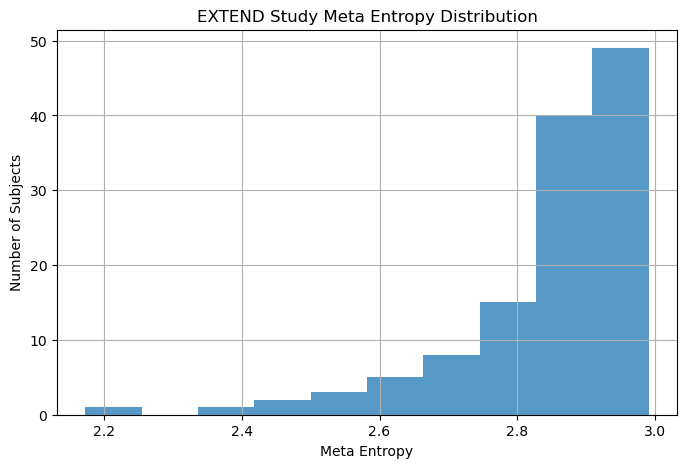

In [27]:
for study, metas in meta_entropies.items():
    if metas:  # if list is not empty
        plt.figure(figsize=(8, 5))
        plt.hist(metas, bins=10, alpha=0.75)
        plt.title(f"{study} Study Meta Entropy Distribution")
        plt.xlabel("Meta Entropy")
        plt.ylabel("Number of Subjects")
        plt.grid(True)
        plt.show()
    else:
        print(f"No meta entropy data for {study}.")


In [28]:
import os

# List to collect summary info for each subject
subject_summary = []

# Create a helper function to extract a subject identifier from the file path
def get_subject_id(file_path):
    # As an example, take the base name (which contains the subject id info)
    return os.path.basename(file_path)

# Process subjects from each study and store results in subject_summary
for study, file_list in [("EXTEND", extend_files)]:
    for file in file_list:
        daily_summary, meta_ent = process_subject(file)
        if meta_ent is not None:
            subject_id = get_subject_id(file)
            subject_summary.append({
                "study": study,
                "subject_id": subject_id,
                "meta_entropy": meta_ent
            })

# Convert the list to a DataFrame
summary_df = pd.DataFrame(subject_summary)

# Inspect the summary DataFrame
print(summary_df.head())

# Save the summary DataFrame to a CSV file
summary_df.to_csv("meta_entropy_summary.csv", index=False)
print("Saved summary to meta_entropy_summary.csv")


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(
/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(
/var/folders/1w/l9hx8l952r57k_qm

    study                               subject_id  meta_entropy
0  EXTEND  sub-2450_ses-accel1_accel.csv.RData.csv      2.797357
1  EXTEND  sub-2557_ses-accel1_accel.csv.RData.csv      2.967972
2  EXTEND  sub-2167_ses-accel1_accel.csv.RData.csv      2.905760
3  EXTEND  sub-2219_ses-accel1_accel.csv.RData.csv      2.939361
4  EXTEND  sub-2314_ses-accel1_accel.csv.RData.csv      2.921021
Saved summary to meta_entropy_summary.csv


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_52453/2342787335.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_summary = df.groupby('date', group_keys=False).apply(


In [29]:
print(df['timestamp'].head())
print(df['timestamp'].dtype)
df['date'] = df['timestamp'].dt.floor('D')



NameError: name 'df' is not defined

Processing file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120001\ses-pre\beh\output_beh\meta\csv\sub-GE120001_ses-pre_accel.csv.RData.csv
Rows with unparseable timestamps: 0 out of 120780
timestamp dtype: datetime64[ns, UTC]
Processing file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120002\ses-pre\beh\output_beh\meta\csv\sub-GE120002_ses-pre_accel.csv.RData.csv
Rows with unparseable timestamps: 0 out of 120780
timestamp dtype: datetime64[ns, UTC]
Processing file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120003\ses-pre\beh\output_beh\meta\csv\sub-GE120003_ses-pre_accel.csv.RData.csv
Rows with unparseable timestamps: 0 out of 120780
timestamp dtype: datetime64[ns, UTC]
Processing file: \\itf-rs-store24.hpc.uiowa.edu\vosslabhpc\Projects\BETTER\3-Experiment\2-data\bids\derivatives\GGIR\sub-GE120004\